In [46]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import (
    LinearRegressionModel,
    RandomForestRegressionModel,
    GBTRegressionModel,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = (
    SparkSession.builder
    .appName("Midterm Project - Evaluation")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [34]:
data_path = "../data/processed/processed_medical_cost.parquet"
df_preprocessed = spark.read.parquet(data_path)

df_preprocessed.show(5)

+---------+---+------+------+-----------+--------+------------+--------------+-----------------+--------------+----------+----+------+------------+----------------+--------------------------+---------------------------+----------------+-----------+------------+-----+-----+---------+------------+----------+-----+-----------------+------------------------+----------------+----------+--------------+-------------+------------+--------+------+----+----------------------+--------------+--------------+-------------+---------+-------------+------------------+------------------+-----------------+------------------+--------------+------------+-------------------+-----------+--------------+-------------------+-----------------+----------------------+-------------------------+--------------+--------------------+-----------------+--------------------+-------------+--------------+-------------------+-----------------+----------------------+-------------------------+--------------+-------------------

In [35]:
train_df, test_df = df_preprocessed.randomSplit([0.8, 0.2], seed=42)
print(f"Train count: {train_df.count()}, Test count: {test_df.count()}")

Train count: 80109, Test count: 19891


In [36]:
evaluator = RegressionEvaluator(
    labelCol="annual_medical_cost",
    predictionCol="prediction"
)

In [37]:
base_path = "../models"

# model dasar
lr_model = LinearRegressionModel.load(f"{base_path}/linear_regression_model")
rf_model = RandomForestRegressionModel.load(f"{base_path}/random_forest_model")
gbt_model = GBTRegressionModel.load(f"{base_path}/gbt_model")

# model hasil tuning (best model)
best_lr_model = LinearRegressionModel.load(f"{base_path}/best_linear_regression_model")
best_rf_model = RandomForestRegressionModel.load(f"{base_path}/best_random_forest_model")
best_gbt_model = GBTRegressionModel.load(f"{base_path}/best_gbt_model")

print("Semua model berhasil di-load.")

Semua model berhasil di-load.


In [38]:
def evaluate_regression(pred_df, name, evaluator):
    mae = evaluator.setMetricName("mae").evaluate(pred_df)
    rmse = evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = evaluator.setMetricName("r2").evaluate(pred_df)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:.4f}")
    return {"model": name, "mae": mae, "rmse": rmse, "r2": r2}

In [39]:
results = []

# model dasar
lr_pred = lr_model.transform(test_df)
results.append(evaluate_regression(lr_pred, "Linear Regression", evaluator))

rf_pred = rf_model.transform(test_df)
results.append(evaluate_regression(rf_pred, "Random Forest", evaluator))

gbt_pred = gbt_model.transform(test_df)
results.append(evaluate_regression(gbt_pred, "GBT Regressor", evaluator))

# model tuned
best_lr_pred = best_lr_model.transform(test_df)
results.append(evaluate_regression(best_lr_pred, "Linear Regression (Tuned)", evaluator))

best_rf_pred = best_rf_model.transform(test_df)
results.append(evaluate_regression(best_rf_pred, "Random Forest (Tuned)", evaluator))

best_gbt_pred = best_gbt_model.transform(test_df)
results.append(evaluate_regression(best_gbt_pred, "GBT Regressor (Tuned)", evaluator))


=== Linear Regression ===
MAE : 312.94
RMSE: 559.02
R²  : 0.9659



=== Random Forest ===
MAE : 292.09
RMSE: 827.27
R²  : 0.9253

=== GBT Regressor ===
MAE : 188.08
RMSE: 843.83
R²  : 0.9222

=== Linear Regression (Tuned) ===
MAE : 312.88
RMSE: 559.01
R²  : 0.9659



=== Random Forest (Tuned) ===
MAE : 203.08
RMSE: 762.64
R²  : 0.9365

=== GBT Regressor (Tuned) ===
MAE : 203.67
RMSE: 787.70
R²  : 0.9322


In [40]:
results_df = pd.DataFrame(results)
results_df

,model,mae,rmse,r2
0,Linear Regression,312.941570,559.022519,0.965867
1,Random Forest,292.088540,827.269134,0.925251
2,GBT Regressor,188.079384,843.834401,0.922228
3,Linear Regression (Tuned),312.882456,559.013938,0.965868
4,Random Forest (Tuned),203.084086,762.635719,0.936475
5,GBT Regressor (Tuned),203.672257,787.699694,0.932231


In [41]:
tuned_df = results_df[results_df["model"].str.contains("Tuned", case=False, na=False)]

ranked = (
    tuned_df
    .sort_values(by="r2", ascending=False)
    .reset_index(drop=True)
)
ranked["Rank"] = ranked.index + 1
ranked[["Rank", "model", "mae", "rmse", "r2"]]

,Rank,model,mae,rmse,r2
0,1,Linear Regression (Tuned),312.882456,559.013938,0.965868
1,2,Random Forest (Tuned),203.084086,762.635719,0.936475
2,3,GBT Regressor (Tuned),203.672257,787.699694,0.932231


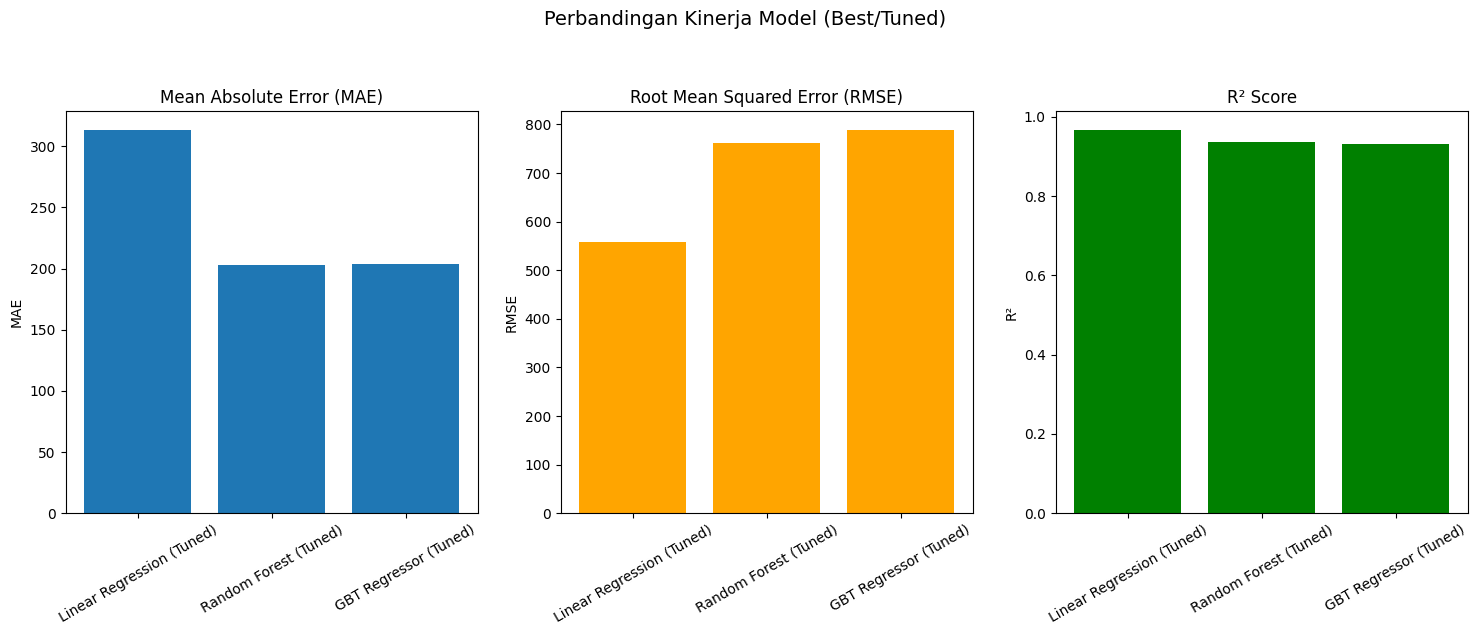

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# MAE
axes[0].bar(tuned_df["model"], tuned_df["mae"])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE")
axes[0].tick_params(axis='x', rotation=30)

# RMSE
axes[1].bar(tuned_df["model"], tuned_df["rmse"], color='orange')
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("RMSE")
axes[1].tick_params(axis='x', rotation=30)

# R²
axes[2].bar(tuned_df["model"], tuned_df["r2"], color='green')
axes[2].set_title("R² Score")
axes[2].set_ylabel("R²")
axes[2].tick_params(axis='x', rotation=30)

plt.suptitle("Perbandingan Kinerja Model (Best/Tuned)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

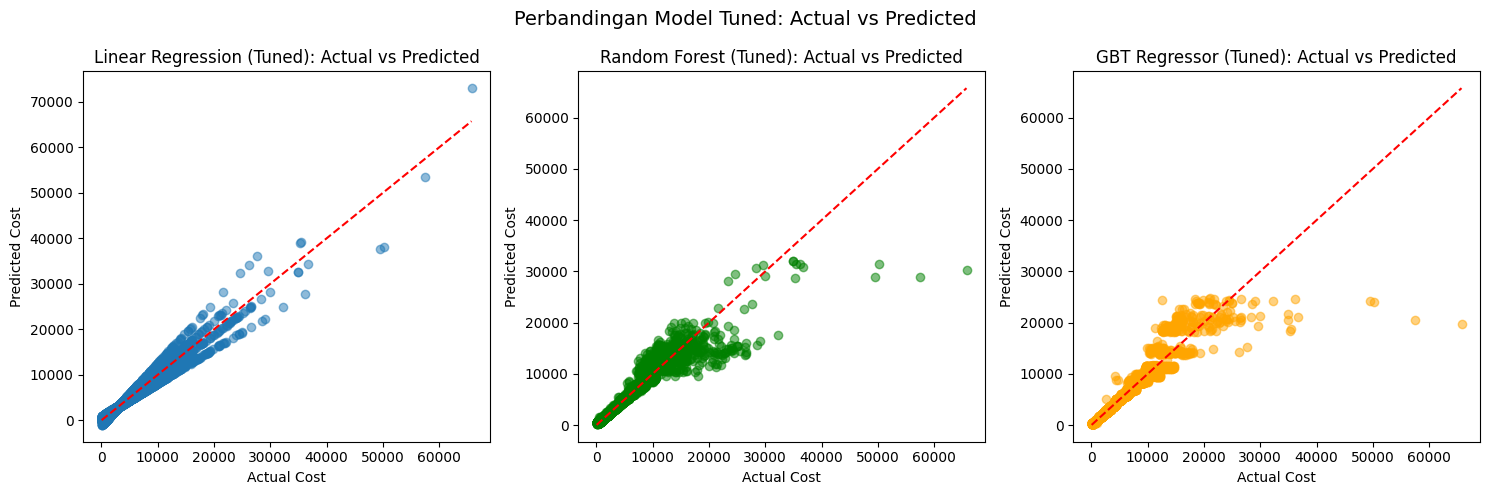

In [43]:
lr_pd = best_lr_pred.select("annual_medical_cost", "prediction").toPandas()
rf_pd = best_rf_pred.select("annual_medical_cost", "prediction").toPandas()
gbt_pd = best_gbt_pred.select("annual_medical_cost", "prediction").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Linear Regression
axes[0].scatter(lr_pd["annual_medical_cost"], lr_pd["prediction"], alpha=0.5)
axes[0].plot(
    [lr_pd["annual_medical_cost"].min(), lr_pd["annual_medical_cost"].max()],
    [lr_pd["annual_medical_cost"].min(), lr_pd["annual_medical_cost"].max()],
    'r--'
)
axes[0].set_title("Linear Regression (Tuned): Actual vs Predicted")
axes[0].set_xlabel("Actual Cost")
axes[0].set_ylabel("Predicted Cost")

# Random Forest
axes[1].scatter(rf_pd["annual_medical_cost"], rf_pd["prediction"], alpha=0.5, color="green")
axes[1].plot(
    [rf_pd["annual_medical_cost"].min(), rf_pd["annual_medical_cost"].max()],
    [rf_pd["annual_medical_cost"].min(), rf_pd["annual_medical_cost"].max()],
    'r--'
)
axes[1].set_title("Random Forest (Tuned): Actual vs Predicted")
axes[1].set_xlabel("Actual Cost")
axes[1].set_ylabel("Predicted Cost")

# GBT
axes[2].scatter(gbt_pd["annual_medical_cost"], gbt_pd["prediction"], alpha=0.5, color="orange")
axes[2].plot(
    [gbt_pd["annual_medical_cost"].min(), gbt_pd["annual_medical_cost"].max()],
    [gbt_pd["annual_medical_cost"].min(), gbt_pd["annual_medical_cost"].max()],
    'r--'
)
axes[2].set_title("GBT Regressor (Tuned): Actual vs Predicted")
axes[2].set_xlabel("Actual Cost")
axes[2].set_ylabel("Predicted Cost")

plt.suptitle("Perbandingan Model Tuned: Actual vs Predicted", fontsize=14)
plt.tight_layout()
plt.show()

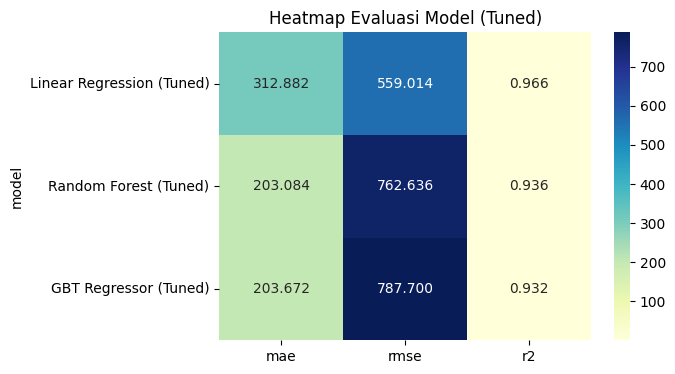

In [47]:
plt.figure(figsize=(6,4))
sns.heatmap(
    tuned_df.set_index("model")[["mae","rmse","r2"]],
    annot=True,
    fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Heatmap Evaluasi Model (Tuned)")
plt.show()